# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [258]:
# Imports here
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
import re
import json
from collections import OrderedDict
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [259]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [260]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_test_transforms = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=valid_test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [266]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [267]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [159]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [175]:
m_test = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/damir.stazic/.cache/torch/checkpoints/resnet34-333f7ec4.pth
97.9%

In [183]:
m_test.__dict__.keys()

dict_keys(['training', '_parameters', '_buffers', '_backward_hooks', '_forward_hooks', '_forward_pre_hooks', '_state_dict_hooks', '_load_state_dict_pre_hooks', '_modules', '_norm_layer', 'inplanes', 'dilation', 'groups', 'base_width'])

In [199]:
type(m_test.__dict__["_modules"]["fc"])

torch.nn.modules.linear.Linear

In [217]:
m_test.__dict__["_modules"].keys()

odict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])

In [210]:
dir(torch.nn.modules.linear.Linear)

['__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_get_name',
 '_load_from_state_dict',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'half',
 'load_state_dict',
 'modules',
 'named_buffers',
 'named_children',
 'named_modules',
 'named_parameters',
 'parameters',
 'register_backward_hook',
 'register_buffer',
 'regi

In [219]:
m_test.__dict__["_modules"]["fc"]

Linear(in_features=512, out_features=1000, bias=True)

In [220]:
m_test.fc

Linear(in_features=512, out_features=1000, bias=True)

In [166]:
m_test.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [168]:
m_test.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [163]:
dir(m_test)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_impl',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_make_layer',
 '_modules',
 '_named_members',
 '_norm_layer',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'avgpool',
 'base_width',
 'bfloat16',
 'bn1',
 'buffers',
 'children',
 'conv1',
 'cpu',
 'cuda',
 'dilation',
 'double',
 

In [162]:
m_test.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('conv1',
               Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
              ('bn1',
               BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
              ('relu', ReLU(inplace=True)),
              ('maxpool',
               MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
              ('layer1', Sequential(
                 (0): BasicBlock(
                   (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                   (relu): ReLU(inplac

### Load pretrained model

In [187]:
model = models.vgg11(pretrained=True)

In [221]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [216]:
"classifier" in model.__dict__["_modules"].keys()

True

In [235]:
model = models.vgg11(pretrained=True)

In [236]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### Define new classifier
**iteration 1**  
>-2 hidden layers (each ReLU activated: 256, 128)  
>-dropout for each hidden layer using 20% dropout probability  
>-10 epochs

In [243]:
class Classifier(nn.Module):
    """
    wrapper for feedforward-only network
    -> backpropagation logic will be provided by pretrained model
    
    param input_size: number of features (int or list)
    param output_size: number of classes (int)
    param hidden_layers: size of each hidden layer (list)
    param dropout: dropout probability (float; default = 0.2)
    """
    
    def __init__(self, input_size, output_size, hidden_layers, dropout=0.2):
        super().__init__()
        self.input_size = [input_size] if isinstance(input_size, int) else input_size
        self.output_size = output_size
        input_all = self.input_size + hidden_layers
        self.hidden_layers = nn.ModuleList([nn.Linear(in_feat, out_feat) 
                                           for in_feat, out_feat in zip(input_all[:-1], input_all[1:])])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        """
        feed forward pass with each hidden layer output being relu activated and randomly 
        ommiting a percentage (specified by dropout) of hidden units. Log-Softmax is used for 
        activation of output layer results.
        """
        # flatten input vector
        x = x.view(x.shape[0],-1)
        print(x.shape)
        for hl in self.hidden_layers:
            # linear combination and relu transformation of input feature
            x = F.relu(hl(x))
            x = self.dropout(x)
        x = self.output(x)
        return F.log_softmax(x, dim=1)

In [237]:
# number of features to be used based on the pre-trained model        
in_features = model.classifier[0].in_features 

In [238]:
# freeze weights of pre-trained model
for param in model.parameters():
    param.requires_grad = False

In [239]:
classifier = Classifier(in_features, len(cat_to_name), [256, 128])
model.classifier = classifier 

In [256]:
model._modules

OrderedDict([('features', Sequential(
                (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): ReLU(inplace=True)
                (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
                (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (4): ReLU(inplace=True)
                (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
                (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (7): ReLU(inplace=True)
                (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (9): ReLU(inplace=True)
                (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
                (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (12): ReLU(inplace=True)
                (13): Conv2d(5

In [230]:
model.classifier.parameters()

<generator object Module.parameters at 0x1a2fde9a8>

In [232]:
model.parameters()

<generator object Module.parameters at 0x1a2fdeb10>

In [240]:
criterion = nn.NLLLoss()
# configure optimizer such that only classifier weights are optimized 
optimizer = optim.Adam(classifier.parameters(), lr=0.003)
# configuration to define how subsequent tensor computations should be conducted
# 1. if possible use GPU memory to run parallel computations
# 2. if no GPU setup available, use CPU in combination with RAM for sequential computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [241]:
# TODO: Build and train your network
def apply_model(epochs=1, **options):
    """
    param training: bool (specifies if model should be trained)
    """
   
    def evaluate(imageloader, model):
        """
        param imageloader: pytorch dataloader
        param model: pytorch model representation
        """
        nonlocal eval_loss
        nonlocal eval_accuracy
        
        # configure model for evaluation:
        # 1. ignore keep tracking of functions along the feedforward pass 
        # 2. inactivate dropout
        with torch.no_grad():
            model.eval()
            for image_batch, label_batch in imageloader:
                # set proper configuration
                image_batch, label_batch = image_batch.to(device), label_batch.to(device) 
                # do forward pass and calculate loss
                output = model.forward(image_batch)
                eval_loss += criterion(output, label_batch)
                # convert model output to class probabilities 
                class_prob = torch.exp(output)
                # calculate accuracy for validation set
                # 1. compare predicted class to true class for each batch
                # --> reshape label tensor to match shape of class_prediction tensor 
                # 2. accumulate number of correctly predicted classes 
                prob, top_class = class_prob.topk(1,dim=1)
                prediction = top_class == label_batch.view(*top_class.shape)
                eval_accuracy += torch.mean(prediction.type(torch.FloatTensor))
                
        # reset model configuration to training mode (dropout used for training)        
        model.train()
    
    train_loss_by_epoch = []
    valid_loss_by_epoch = []
    valid_accuracy_by_epoch = []
    
    print("Training and validating model" if not options.get("only_validate") else "Only validation activated")
    for e in range(epochs):
        # iterate over all batches in training data and train classifier
        train_loss = 0
        eval_loss = 0
        eval_accuracy = 0
        
        if options.get("only_validate"):
            imageloader = options.get("only_validate")
            evaluate(imageloader, model)
            avg_test_loss = round((eval_loss/len(imageloader)).item(), 3)
            avg_test_accuracy = round((eval_accuracy/len(imageloader)).item(), 3)
            print(f"Test loss: {avg_test_loss}\n"
                  f"Test accuracy: {avg_test_accuracy}")
            return
        
        for idx, (image_batch, label_batch) in enumerate(train_dataloader):
            # set proper configuration
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            # reset gradient to zero to avoid gradient accumulation 
            # for all subsequent forward pass/backpropagation steps
            optimizer.zero_grad()

            # do forward pass and calculate loss
            output = model.forward(image_batch)
            loss = criterion(output, label_batch)

            # do backpropagation
            loss.backward()

            # update weights
            optimizer.step()

            # accumulate avg batch loss   
            train_loss += loss
            
        # evaluate model using the appropriate evaluation set
        # 1. validation set for different models
        # 2. test set for generalization
        evaluate(valid_dataloader, model)
        
        # keep track of avg loss/accuracy by epoch 
        avg_train_loss_by_epoch = round((train_loss/len(train_dataloader)).item(), 3)
        avg_test_loss_by_epoch = round((eval_loss/len(valid_dataloader)).item(), 3)
        avg_test_accuracy_by_epoch = round((eval_accuracy/len(valid_dataloader)).item(), 3)

        train_loss_by_epoch.append(avg_train_loss_by_epoch) 
        valid_loss_by_epoch.append(avg_test_loss_by_epoch) 
        valid_accuracy_by_epoch.append(avg_test_accuracy_by_epoch) 

        msg = f"Epoch: {e+1}\n\
        Train Loss (avg): {avg_train_loss_by_epoch}\n\
        Test Loss (avg): {avg_test_loss_by_epoch}\n\
        Test Accuracy (avg) {avg_test_accuracy_by_epoch}\n\
        -------------------"
        print(msg)
        
    metrics = {"train_loss_by_epoch": train_loss_by_epoch,
               "valid_loss_by_epoch": valid_loss_by_epoch,
               "valid_accuracy_by_epoch": valid_accuracy_by_epoch}
    
    return metrics

In [244]:
metrics = apply_model(epochs=1)

Training and validating model


KeyboardInterrupt: 

In [14]:
metrics = apply_model(epochs=10)

Training and validating model
Epoch: 1
        Train Loss (avg): 3.415
        Test Loss (avg): 1.71
        Test Accuracy (avg) 0.545
        -------------------
Epoch: 2
        Train Loss (avg): 2.275
        Test Loss (avg): 1.373
        Test Accuracy (avg) 0.618
        -------------------
Epoch: 3
        Train Loss (avg): 2.035
        Test Loss (avg): 1.096
        Test Accuracy (avg) 0.684
        -------------------
Epoch: 4
        Train Loss (avg): 1.798
        Test Loss (avg): 1.046
        Test Accuracy (avg) 0.709
        -------------------
Epoch: 5
        Train Loss (avg): 1.742
        Test Loss (avg): 0.996
        Test Accuracy (avg) 0.746
        -------------------
Epoch: 6
        Train Loss (avg): 1.65
        Test Loss (avg): 0.971
        Test Accuracy (avg) 0.748
        -------------------
Epoch: 7
        Train Loss (avg): 1.683
        Test Loss (avg): 0.926
        Test Accuracy (avg) 0.734
        -------------------
Epoch: 8
        Train Loss (avg):

In [16]:
# save metrics 
with open("metrics_iteration_1", "w") as f_out:
    json.dump(metrics, f_out)

#### Bias versus variance assessment 

In [15]:
def plot_loss(metrics_summary, figsize=(5,5)):
    epochs = len(metrics_summary["train_loss_by_epoch"])
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([i for i in range(1,epochs+1)], metrics_summary["train_loss_by_epoch"], label="Training loss")
    ax.plot([i for i in range(1,epochs+1)], metrics_summary["valid_loss_by_epoch"], label="Validation loss")
    ax.set_xlim(1,epochs+1)
    ax.set_xticks([i for i in range(1,epochs+1)])
    plt.legend(frameon=False)
    plt.show() 

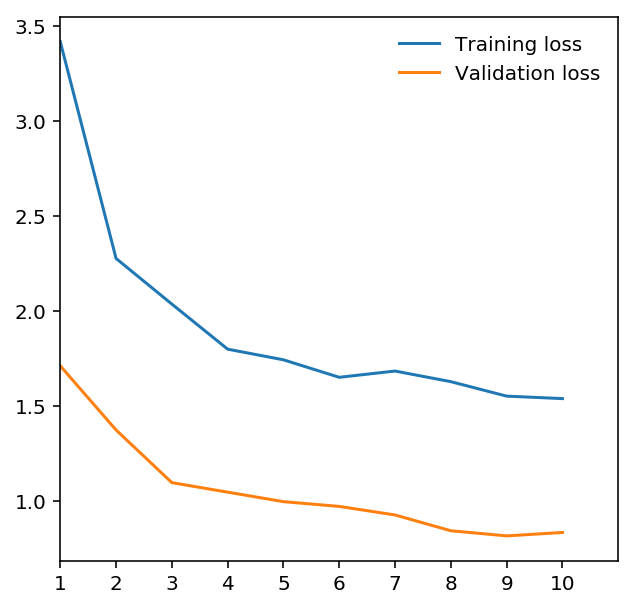

In [16]:
with open("metrics_iteration_1", "r") as f_in:
    metrics = json.load(f_in)
    
plot_loss(metrics)    

Both, validation loss and training loss decrease with every epoch of model training. Also, we can see the effect of regularization via dropout. Training loss is not significantly lower in comparison to validation loss. Especially, with progressing training epoch, the rate of loss decrease does not change significantly between training set and validation set. As such, we can exclude any significant effect due to variance (training loss would exhibit a much more prominent decrease as opposed to validaqtion loss). With a accuracy of almost 80%, the model already seems to exhibit good generalization. high accuracy for the validation set also suggests that the model does not suffer significantly from bias. Let's increase the number of epochs first to evaluate if loss will decrease further or if it's already flatting out. If the latter is true, it would suggest to increase model complexity (e.g., increase number of hidden units) to increase accuracy.    

**iteration 2**  
>-2 hidden layers (each ReLU activated; 256, 128)  
>-dropout for each hidden layer using 20% dropout probability  
>-20 epochs

In [ ]:
# either keep training for 10 epochs or reset optimizer if repeating training 
optimizer = optim.Adam(classifier.parameters(), lr=0.003)

In [27]:
metrics = apply_model(epochs=20)
# save metrics 
with open("metrics_iteration_2", "w") as f_out:
    json.dump(metrics, f_out)

Training and validating model
Epoch: 1
        Train Loss (avg): 3.582
        Test Loss (avg): 1.855
        Test Accuracy (avg) 0.512
        -------------------
Epoch: 2
        Train Loss (avg): 2.423
        Test Loss (avg): 1.358
        Test Accuracy (avg) 0.641
        -------------------
Epoch: 3
        Train Loss (avg): 2.059
        Test Loss (avg): 1.283
        Test Accuracy (avg) 0.648
        -------------------
Epoch: 4
        Train Loss (avg): 1.932
        Test Loss (avg): 1.11
        Test Accuracy (avg) 0.674
        -------------------
Epoch: 5
        Train Loss (avg): 1.857
        Test Loss (avg): 0.966
        Test Accuracy (avg) 0.718
        -------------------
Epoch: 6
        Train Loss (avg): 1.759
        Test Loss (avg): 0.937
        Test Accuracy (avg) 0.735
        -------------------
Epoch: 7
        Train Loss (avg): 1.728
        Test Loss (avg): 0.966
        Test Accuracy (avg) 0.739
        -------------------
Epoch: 8
        Train Loss (avg)

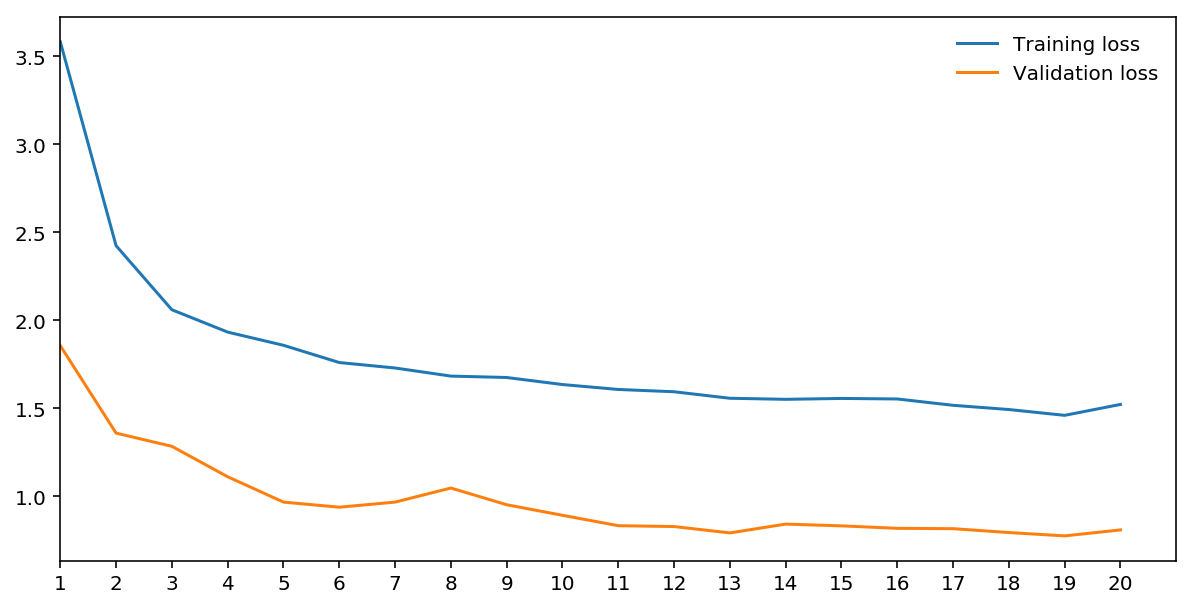

In [67]:
with open("metrics_iteration_2", "r") as f_in:
    metrics_iteration_2 = json.load(f_in)
    
plot_loss(metrics_iteration_2)      

**iteration 3**  
>-3 hidden layers (each ReLU activated; 256, 256, 128)  
>-dropout for each hidden layer using 20% dropout probability  
>-20 epochs

In [10]:
# reset optimizer since training a new architecture
optimizer = optim.Adam(classifier.parameters(), lr=0.003)

# freeze weights of pre-trained model
for param in model.parameters():
    param.requires_grad = False
    
classifier = Classifier(in_features, len(cat_to_name), [256, 256, 128])
model.classifier = classifier 

In [11]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [14]:
metrics = apply_model(epochs=20)
# save metrics 
with open("metrics_iteration_3", "w") as f_out:
    json.dump(metrics, f_out)

Training and validating model
Epoch: 1
        Train Loss (avg): 3.722
        Test Loss (avg): 2.534
        Test Accuracy (avg) 0.347
        -------------------
Epoch: 2
        Train Loss (avg): 2.637
        Test Loss (avg): 1.561
        Test Accuracy (avg) 0.559
        -------------------
Epoch: 3
        Train Loss (avg): 2.226
        Test Loss (avg): 1.354
        Test Accuracy (avg) 0.636
        -------------------
Epoch: 4
        Train Loss (avg): 2.053
        Test Loss (avg): 1.228
        Test Accuracy (avg) 0.662
        -------------------
Epoch: 5
        Train Loss (avg): 2.054
        Test Loss (avg): 1.277
        Test Accuracy (avg) 0.632
        -------------------
Epoch: 6
        Train Loss (avg): 1.946
        Test Loss (avg): 1.022
        Test Accuracy (avg) 0.723
        -------------------
Epoch: 7
        Train Loss (avg): 1.794
        Test Loss (avg): 1.122
        Test Accuracy (avg) 0.674
        -------------------
Epoch: 8
        Train Loss (avg

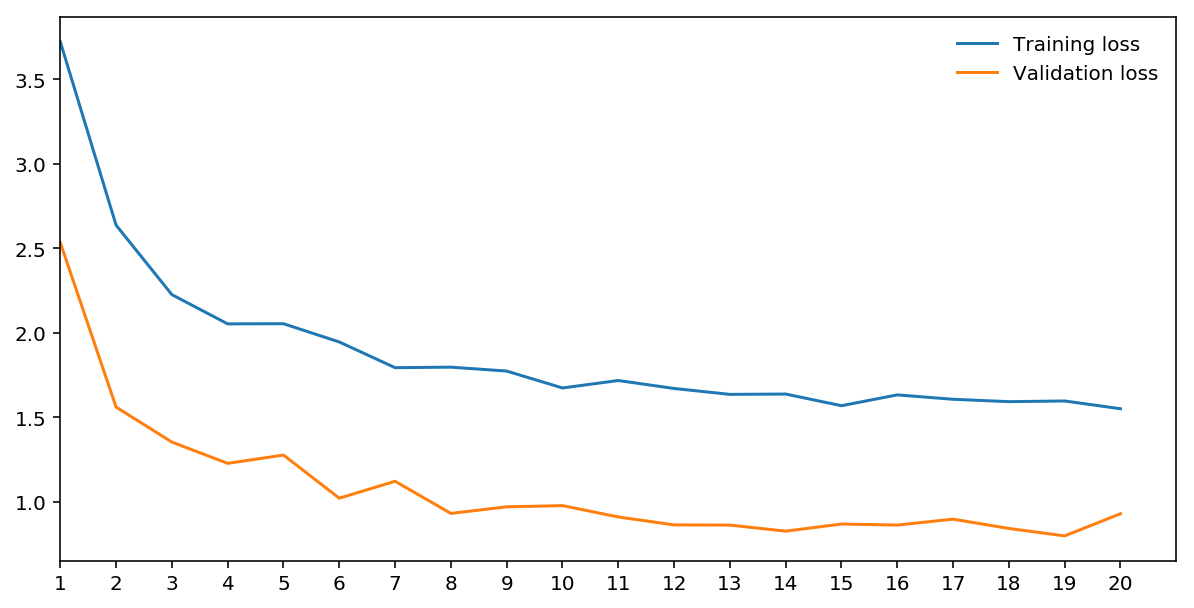

In [69]:
with open("metrics_iteration_3", "r") as f_in:
    metrics_iteration_3 = json.load(f_in)
    
plot_loss(metrics_iteration_3)   

Adding another hidden layer doesn't seem to improve overall model performance. Similar loss reduction and validation accuracy (approx. 80%), respectively, is achieved. Similarly, loss reduction seems to plateau from training epoch 10 onwards. Let's add even more hidden layers and also increase the number of hidden layer units.     

**iteration 4**  
>-4 hidden layers (each ReLU activated; 512, 256, 256, 128)  
>-dropout for each hidden layer using 20% dropout probability  
>-20 epochs

In [40]:
# reset optimizer since training a new architecture
optimizer = optim.Adam(classifier.parameters(), lr=0.003)

# freeze weights of pre-trained model
for param in model.parameters():
    param.requires_grad = False
    
classifier = Classifier(in_features, len(cat_to_name), [512, 256, 256, 128])
model.classifier = classifier 

In [41]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [43]:
metrics = apply_model(epochs=20)
# save metrics 
with open("metrics_iteration_4", "w") as f_out:
    json.dump(metrics, f_out)

Training and validating model
Epoch: 1
        Train Loss (avg): 4.064
        Test Loss (avg): 2.948
        Test Accuracy (avg) 0.255
        -------------------
Epoch: 2
        Train Loss (avg): 3.153
        Test Loss (avg): 2.554
        Test Accuracy (avg) 0.334
        -------------------
Epoch: 3
        Train Loss (avg): 2.772
        Test Loss (avg): 2.049
        Test Accuracy (avg) 0.442
        -------------------
Epoch: 4
        Train Loss (avg): 2.518
        Test Loss (avg): 1.752
        Test Accuracy (avg) 0.538
        -------------------
Epoch: 5
        Train Loss (avg): 2.365
        Test Loss (avg): 1.647
        Test Accuracy (avg) 0.545
        -------------------
Epoch: 6
        Train Loss (avg): 2.27
        Test Loss (avg): 1.519
        Test Accuracy (avg) 0.563
        -------------------
Epoch: 7
        Train Loss (avg): 2.227
        Test Loss (avg): 1.453
        Test Accuracy (avg) 0.597
        -------------------
Epoch: 8
        Train Loss (avg)

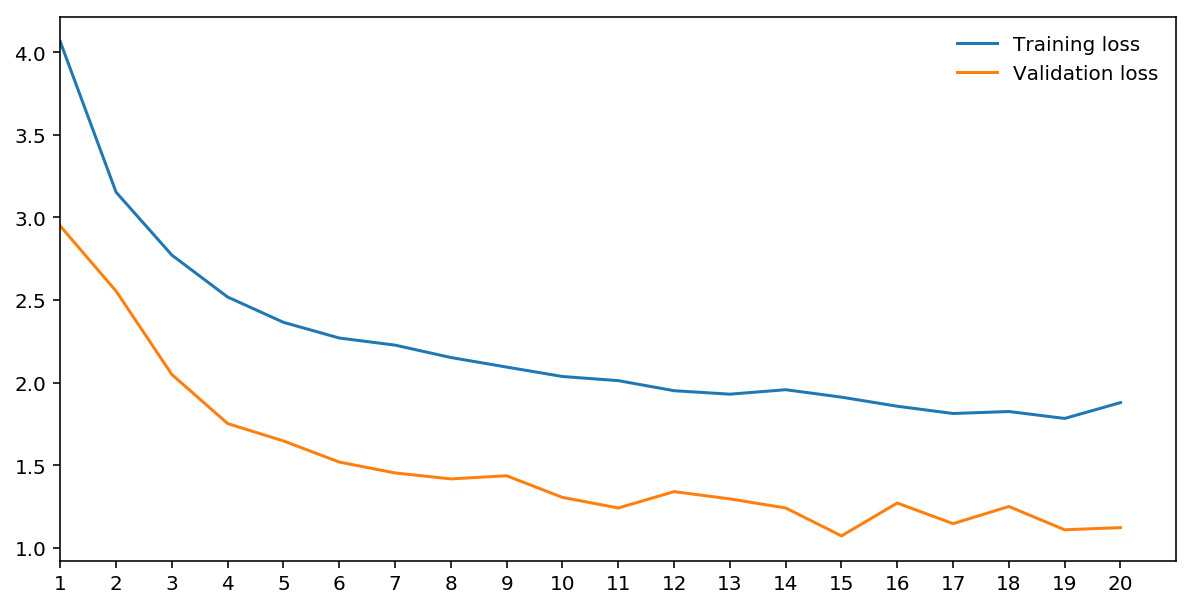

In [70]:
with open("metrics_iteration_4", "r") as f_in:
    metrics_iteration_4 = json.load(f_in)
    
plot_loss(metrics_iteration_4)   

Further increasing model complexity results in reduced model performance (less accuracy for validation set/ higher training and test loss). Having a higher training set loss and validation set loss is usually indicative of increased model bias. However, maybe increasing the number of epochs would be necessary for the more complex model to eventually converge to more optimal parameters, which in turn would result in lower training and validation loss, respectively (and thus model accuracy). So let's train for 10 more epochs.  

In [46]:
metrics = apply_model(epochs=10)

Training and validating model
Epoch: 1
        Train Loss (avg): 1.816
        Test Loss (avg): 1.133
        Test Accuracy (avg) 0.71
        -------------------
Epoch: 2
        Train Loss (avg): 1.792
        Test Loss (avg): 1.154
        Test Accuracy (avg) 0.711
        -------------------
Epoch: 3
        Train Loss (avg): 1.735
        Test Loss (avg): 1.035
        Test Accuracy (avg) 0.752
        -------------------
Epoch: 4
        Train Loss (avg): 1.779
        Test Loss (avg): 1.084
        Test Accuracy (avg) 0.736
        -------------------
Epoch: 5
        Train Loss (avg): 1.773
        Test Loss (avg): 1.045
        Test Accuracy (avg) 0.735
        -------------------
Epoch: 6
        Train Loss (avg): 1.801
        Test Loss (avg): 0.973
        Test Accuracy (avg) 0.748
        -------------------
Epoch: 7
        Train Loss (avg): 1.761
        Test Loss (avg): 0.991
        Test Accuracy (avg) 0.764
        -------------------
Epoch: 8
        Train Loss (avg)

*Either extend previous metrics (if running from scratch) or load already saved metrics*

In [53]:
for k in metrics_iteration_4.keys():
    metrics_iteration_4[k].extend(metrics[k])

In [57]:
with open("metrics_iteration_4_30_epochs", "w") as f_out:
    json.dump(metrics_iteration_4, f_out)

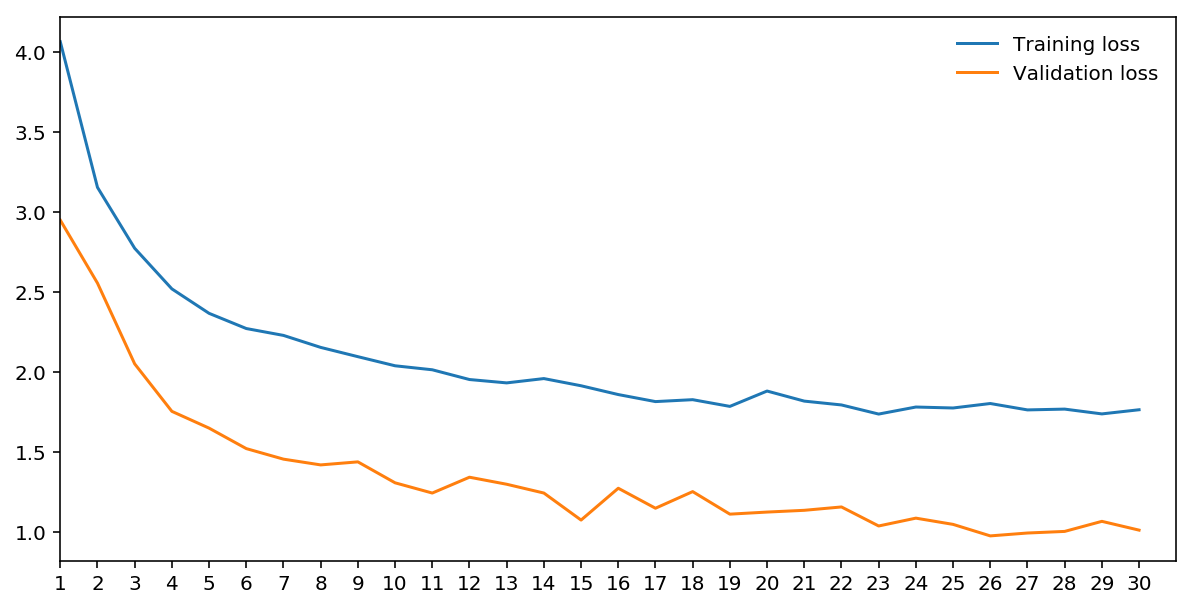

In [71]:
with open("metrics_iteration_4_30_epochs", "r") as f_in:
    metrics_iteration_4_30_epochs = json.load(f_in)
    
plot_loss(metrics_iteration_4_30_epochs)   

The results support our assumption that increasing model complexity seems to require more epochs to train in order to be able to achieve similar results when training less complex models. Let's see if training loss and validation test loss still keep dropping if we continue training our model for another 10 epochs. 

In [59]:
metrics = apply_model(epochs=10)

Training and validating model
Epoch: 1
        Train Loss (avg): 1.823
        Test Loss (avg): 1.112
        Test Accuracy (avg) 0.738
        -------------------
Epoch: 2
        Train Loss (avg): 1.739
        Test Loss (avg): 0.926
        Test Accuracy (avg) 0.767
        -------------------
Epoch: 3
        Train Loss (avg): 1.708
        Test Loss (avg): 1.088
        Test Accuracy (avg) 0.763
        -------------------
Epoch: 4
        Train Loss (avg): 1.75
        Test Loss (avg): 1.026
        Test Accuracy (avg) 0.761
        -------------------
Epoch: 5
        Train Loss (avg): 1.713
        Test Loss (avg): 0.932
        Test Accuracy (avg) 0.783
        -------------------
Epoch: 6
        Train Loss (avg): 1.716
        Test Loss (avg): 1.043
        Test Accuracy (avg) 0.762
        -------------------
Epoch: 7
        Train Loss (avg): 1.631
        Test Loss (avg): 1.026
        Test Accuracy (avg) 0.737
        -------------------
Epoch: 8
        Train Loss (avg)

*Again, either extend previous metrics (if running from scratch) or load already saved metrics*

In [60]:
for k in metrics_iteration_4.keys():
    metrics_iteration_4[k].extend(metrics[k])

In [61]:
with open("metrics_iteration_4_40_epochs", "w") as f_out:
    json.dump(metrics_iteration_4, f_out)

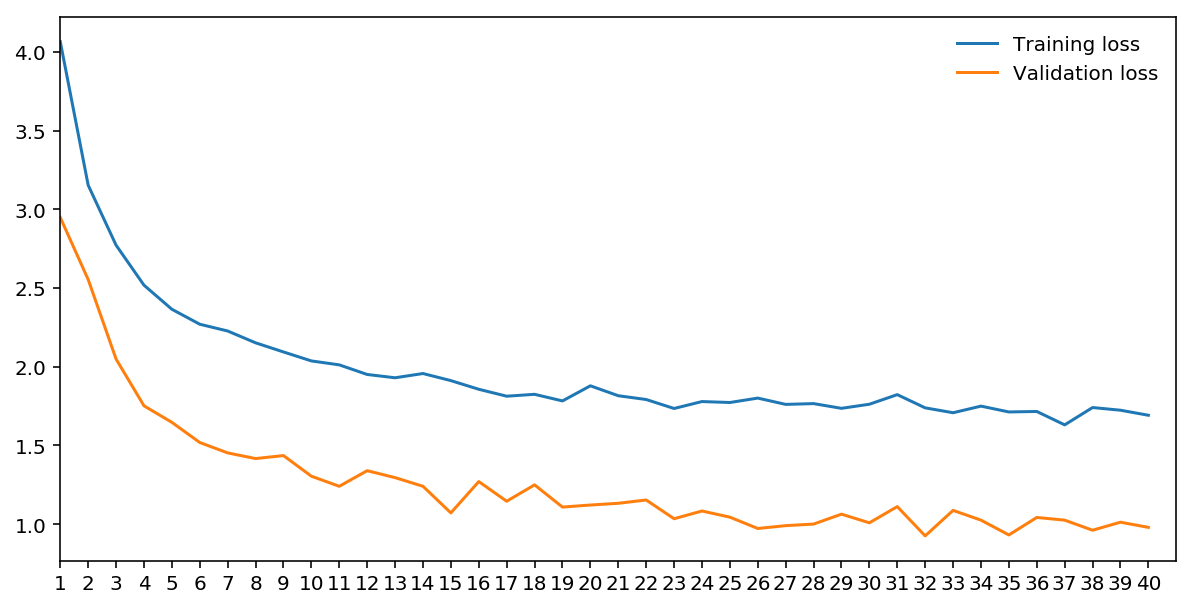

In [72]:
with open("metrics_iteration_4_40_epochs", "r") as f_in:
    metrics_iteration_4_40_epochs = json.load(f_in)
    
plot_loss(metrics_iteration_4_40_epochs)   

Thus far, most bang for buck (best accuracy/lowest loss) model seems to be the one from iteration 2 (2 hidden layers, training for 20 epochs). Training the more complex model from iteration 4 required 40 epochs to reach almost comparable results. Continuing training might increase model accuracy even further. However, I am rather going back to the model from iteration 2 and assessing model performance in terms of accuracy with reduced dropout rates. This would allow more a complex hypothesis to be learned. Essentially, we want the hypothesis to be sufficiantly complex to have the lowest possible training and validation error/loss.   

**iteration 5**  
>-2 hidden layers (each ReLU activated; 256, 128)  
>-dropout for each hidden layer using 10% dropout probability  
>-20 epochs

In [72]:
classifier = Classifier(in_features, len(cat_to_name), [256, 128], dropout=0.1)
model.classifier = classifier 

# reset optimizer since training a new architecture
optimizer = optim.Adam(classifier.parameters(), lr=0.003)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [73]:
metrics = apply_model(epochs=20)

Training and validating model
Epoch: 1
        Train Loss (avg): 3.25
        Test Loss (avg): 1.518
        Test Accuracy (avg) 0.585
        -------------------
Epoch: 2
        Train Loss (avg): 1.969
        Test Loss (avg): 1.132
        Test Accuracy (avg) 0.697
        -------------------
Epoch: 3
        Train Loss (avg): 1.672
        Test Loss (avg): 1.027
        Test Accuracy (avg) 0.727
        -------------------
Epoch: 4
        Train Loss (avg): 1.477
        Test Loss (avg): 0.846
        Test Accuracy (avg) 0.763
        -------------------
Epoch: 5
        Train Loss (avg): 1.394
        Test Loss (avg): 0.837
        Test Accuracy (avg) 0.763
        -------------------
Epoch: 6
        Train Loss (avg): 1.335
        Test Loss (avg): 0.771
        Test Accuracy (avg) 0.8
        -------------------
Epoch: 7
        Train Loss (avg): 1.265
        Test Loss (avg): 0.701
        Test Accuracy (avg) 0.826
        -------------------
Epoch: 8
        Train Loss (avg): 

In [74]:
with open("metrics_iteration_5", "w") as f_out:
    json.dump(metrics, f_out)

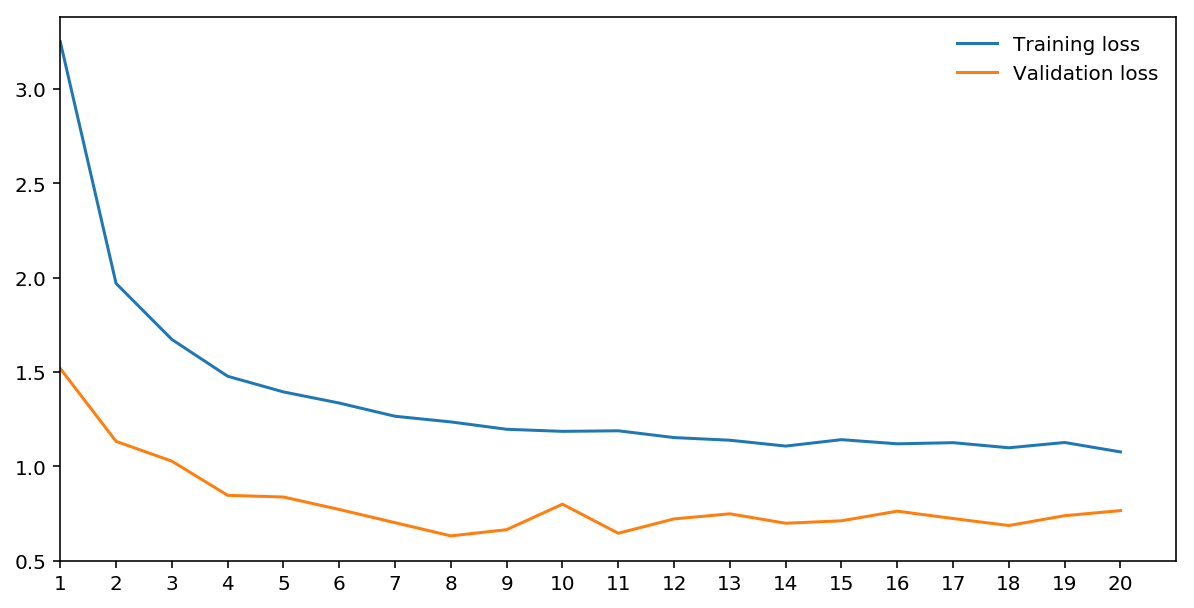

In [76]:
plot_loss(metrics)

Overall, training loss and validation loss are lower than our benchmark model from iteration 2. Also, the accuracy for the validation set increased well above 80%. This suggest that the model was somewhat underfitting before. Let's continue training for another 10 epochs to evaluate if the model exhibits tendencies of overfitting after epoch 10 (training loss seems to decrease whereas validation loss might start increasing) or rather approaches a plateau.

In [78]:
metrics = apply_model(epochs=10)

Training and validating model
Epoch: 1
        Train Loss (avg): 1.059
        Test Loss (avg): 0.73
        Test Accuracy (avg) 0.827
        -------------------
Epoch: 2
        Train Loss (avg): 1.043
        Test Loss (avg): 0.709
        Test Accuracy (avg) 0.835
        -------------------
Epoch: 3
        Train Loss (avg): 1.044
        Test Loss (avg): 0.677
        Test Accuracy (avg) 0.86
        -------------------
Epoch: 4
        Train Loss (avg): 1.092
        Test Loss (avg): 0.799
        Test Accuracy (avg) 0.833
        -------------------
Epoch: 5
        Train Loss (avg): 1.055
        Test Loss (avg): 0.695
        Test Accuracy (avg) 0.834
        -------------------
Epoch: 6
        Train Loss (avg): 1.026
        Test Loss (avg): 0.746
        Test Accuracy (avg) 0.839
        -------------------
Epoch: 7
        Train Loss (avg): 1.015
        Test Loss (avg): 0.651
        Test Accuracy (avg) 0.852
        -------------------
Epoch: 8
        Train Loss (avg):

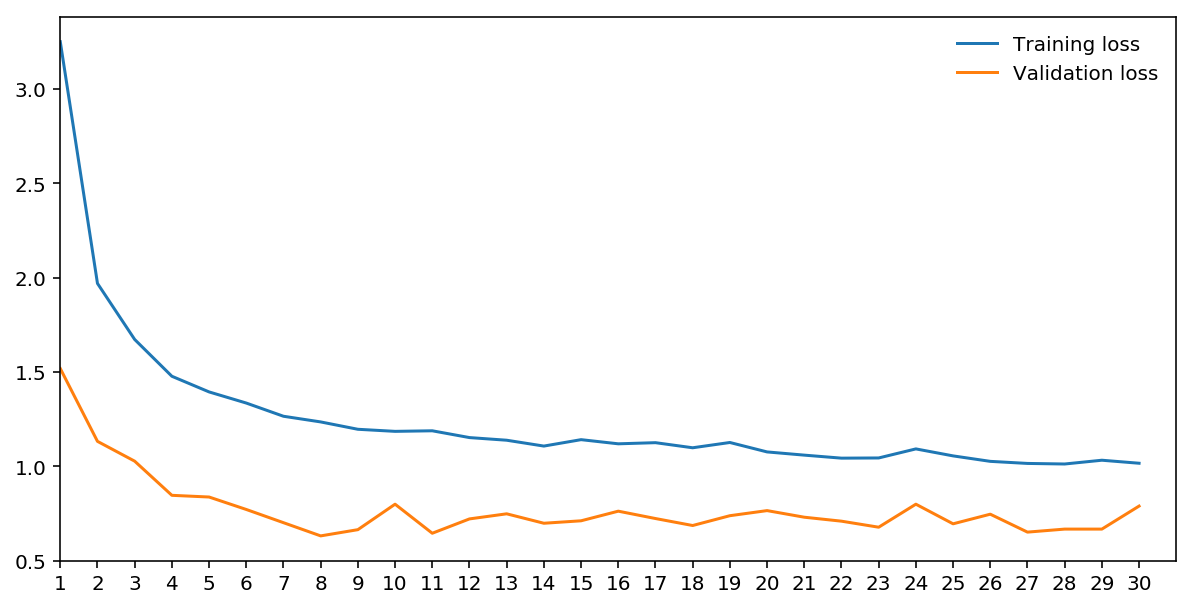

In [81]:
with open("metrics_iteration_5", "r") as f_in:
    metrics_iteration_5 = json.load(f_in)
   
for k in metrics_iteration_5.keys():
    metrics_iteration_5[k].extend(metrics[k])
    
plot_loss(metrics_iteration_5)    

The model does not seem to overfit just yet. So let's try to combine the lower dropout rate of 10% with an additional hidden layer to check if we can further increase accuracy without suffering from high variance/overfitting. 

**iteration 6**  
>-3 hidden layers (each ReLU activated; 256, 256, 128)  
>-dropout for each hidden layer using 10% dropout probability  
>-20 epochs

In [83]:
classifier = Classifier(in_features, len(cat_to_name), [256, 256, 128], dropout=0.1)
model.classifier = classifier 

# reset optimizer since training a new architecture
optimizer = optim.Adam(classifier.parameters(), lr=0.003)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [84]:
metrics = apply_model(epochs=20)

Training and validating model
Epoch: 1
        Train Loss (avg): 3.425
        Test Loss (avg): 2.06
        Test Accuracy (avg) 0.442
        -------------------
Epoch: 2
        Train Loss (avg): 2.159
        Test Loss (avg): 1.334
        Test Accuracy (avg) 0.615
        -------------------
Epoch: 3
        Train Loss (avg): 1.791
        Test Loss (avg): 1.201
        Test Accuracy (avg) 0.669
        -------------------
Epoch: 4
        Train Loss (avg): 1.634
        Test Loss (avg): 1.153
        Test Accuracy (avg) 0.691
        -------------------
Epoch: 5
        Train Loss (avg): 1.537
        Test Loss (avg): 0.915
        Test Accuracy (avg) 0.767
        -------------------
Epoch: 6
        Train Loss (avg): 1.444
        Test Loss (avg): 0.934
        Test Accuracy (avg) 0.73
        -------------------
Epoch: 7
        Train Loss (avg): 1.425
        Test Loss (avg): 0.862
        Test Accuracy (avg) 0.746
        -------------------
Epoch: 8
        Train Loss (avg):

In [85]:
with open("metrics_iteration_6", "w") as f_out:
    json.dump(metrics, f_out)

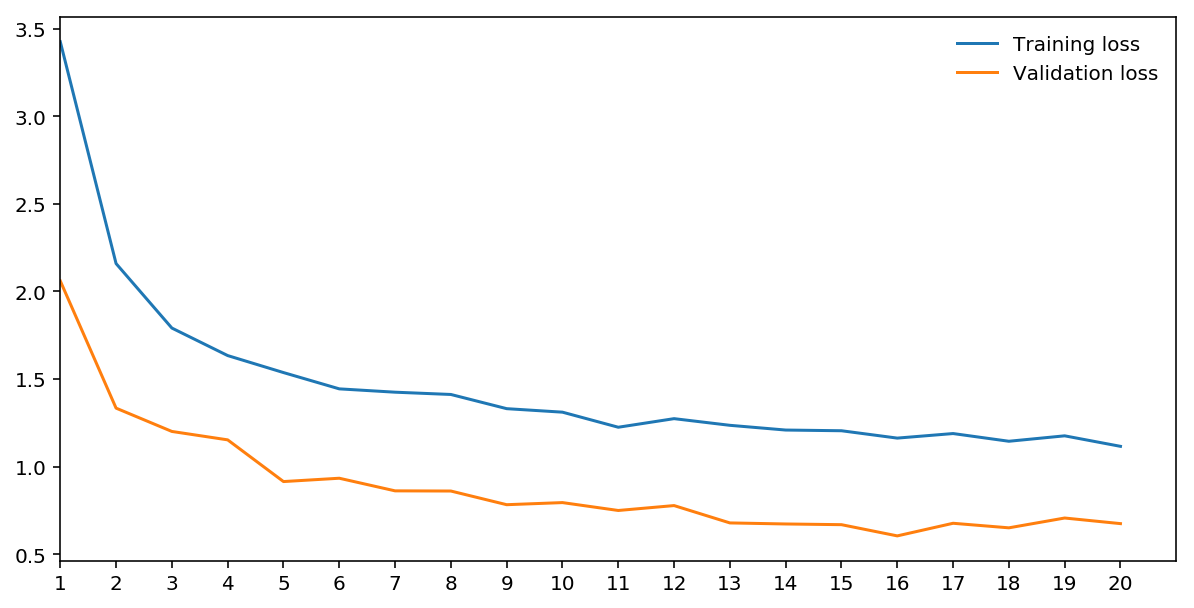

In [86]:
plot_loss(metrics)

This model seems to start approaching a plateau with respect to validation error at a later epoch as opposed to previous model using only 2 hidden layers. Validation loss exibits a slight downwards trend, so let's keep training for another 10 epochs to see if even better accuracy/validation loss can be achieved. 

In [88]:
metrics = apply_model(epochs=10)

Training and validating model
Epoch: 1
        Train Loss (avg): 1.137
        Test Loss (avg): 0.716
        Test Accuracy (avg) 0.827
        -------------------
Epoch: 2
        Train Loss (avg): 1.143
        Test Loss (avg): 0.783
        Test Accuracy (avg) 0.833
        -------------------
Epoch: 3
        Train Loss (avg): 1.128
        Test Loss (avg): 0.619
        Test Accuracy (avg) 0.854
        -------------------
Epoch: 4
        Train Loss (avg): 1.057
        Test Loss (avg): 0.764
        Test Accuracy (avg) 0.836
        -------------------
Epoch: 5
        Train Loss (avg): 1.135
        Test Loss (avg): 0.812
        Test Accuracy (avg) 0.812
        -------------------
Epoch: 6
        Train Loss (avg): 1.074
        Test Loss (avg): 0.662
        Test Accuracy (avg) 0.859
        -------------------
Epoch: 7
        Train Loss (avg): 1.106
        Test Loss (avg): 0.582
        Test Accuracy (avg) 0.86
        -------------------
Epoch: 8
        Train Loss (avg)

In [90]:
with open("metrics_iteration_6", "r") as f_in:
    metrics_iteration_6 = json.load(f_in)
   
for k in metrics_iteration_6.keys():
    metrics_iteration_6[k].extend(metrics[k])
    
with open("metrics_iteration_6_30_epochs", "w") as f_out:
    json.dump(metrics_iteration_6, f_out)    

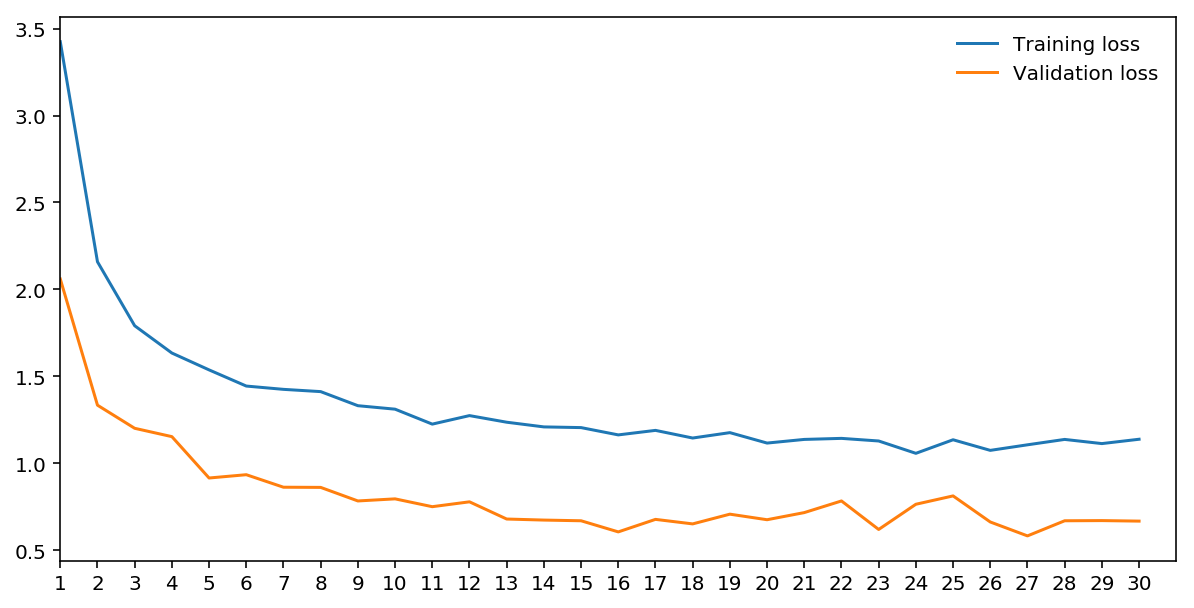

In [91]:
plot_loss(metrics_iteration_6) 

Validation error seems to flatten out after training for 10 epochs. Consequently, I am not going to increase the number of training epochs and instead increase model complexity even further.

In [93]:
# TODO: Save the checkpoint 
checkpoint = {'input_size': classifier.input_size,
              'output_size': classifier.output_size,
              'epochs': 30,
              'hidden_layers': [hl.out_features for hl in classifier.hidden_layers],
              'state_dict': model.state_dict(),
              'optimizer_state': optimizer.state_dict()}

# convert idx class representation to int
# -> not required, but allows direct mapping to class names without converting top class prediction to str
model.class_to_idx = {int(k):v for k,v in cat_to_name.items()}

torch.save(checkpoint, 'checkpoint_iteration_6.pth')

**iteration 7**  
>-4 hidden layers (each ReLU activated; 512, 256, 256, 128)  
>-dropout for each hidden layer using 10% dropout probability  
>-20 epochs

In [19]:
classifier = Classifier(in_features, len(cat_to_name), [512, 256, 256, 128], dropout=0.1)
model.classifier = classifier 

# reset optimizer since training a new architecture
optimizer = optim.Adam(classifier.parameters(), lr=0.003)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [21]:
metrics = apply_model(epochs=20)

Training and validating model
Epoch: 1
        Train Loss (avg): 3.746
        Test Loss (avg): 2.579
        Test Accuracy (avg) 0.335
        -------------------
Epoch: 2
        Train Loss (avg): 2.642
        Test Loss (avg): 1.92
        Test Accuracy (avg) 0.491
        -------------------
Epoch: 3
        Train Loss (avg): 2.238
        Test Loss (avg): 1.657
        Test Accuracy (avg) 0.528
        -------------------
Epoch: 4
        Train Loss (avg): 1.98
        Test Loss (avg): 1.496
        Test Accuracy (avg) 0.604
        -------------------
Epoch: 5
        Train Loss (avg): 1.818
        Test Loss (avg): 1.395
        Test Accuracy (avg) 0.619
        -------------------
Epoch: 6
        Train Loss (avg): 1.775
        Test Loss (avg): 1.28
        Test Accuracy (avg) 0.655
        -------------------
Epoch: 7
        Train Loss (avg): 1.664
        Test Loss (avg): 1.151
        Test Accuracy (avg) 0.699
        -------------------
Epoch: 8
        Train Loss (avg): 

In [22]:
with open("metrics_iteration_7", "w") as f_out:
    json.dump(metrics, f_out)

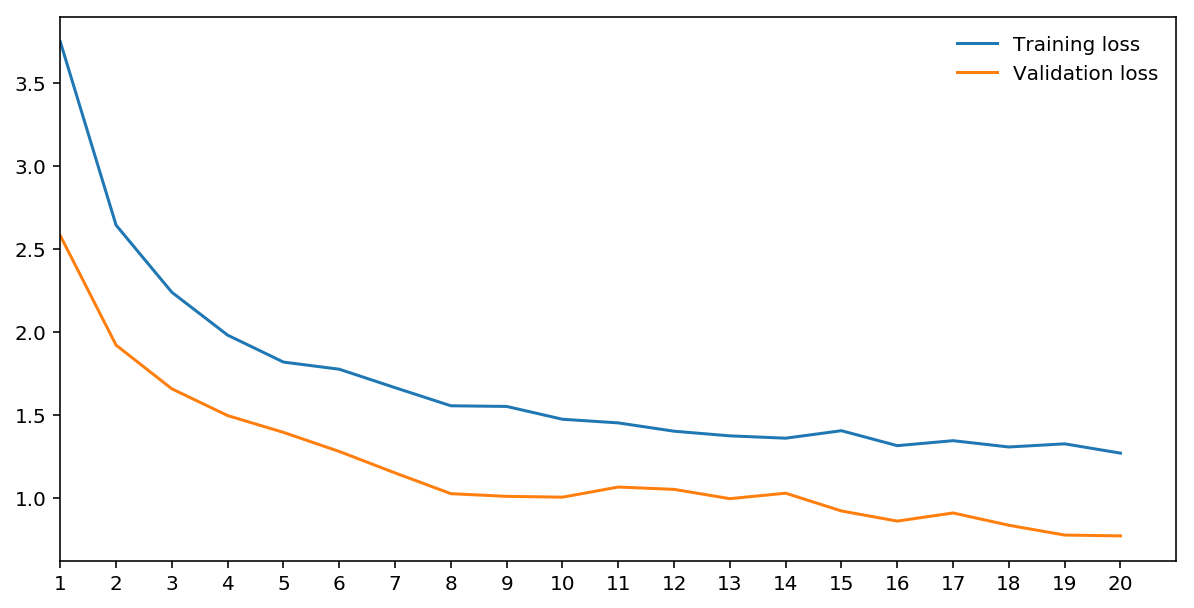

In [24]:
plot_loss(metrics) 

Again, plotting loss as a function of epochs indicates that loss decrease has not yet reached a plateau. This is consistent with previous findings that with increasing model complexity, more epochs are required to reach similar loss levels. Consequently, let's continue training for another 20 epochs

In [25]:
metrics = apply_model(epochs=20)

Training and validating model
Epoch: 1
        Train Loss (avg): 1.223
        Test Loss (avg): 0.77
        Test Accuracy (avg) 0.839
        -------------------
Epoch: 2
        Train Loss (avg): 1.229
        Test Loss (avg): 0.791
        Test Accuracy (avg) 0.821
        -------------------
Epoch: 3
        Train Loss (avg): 1.272
        Test Loss (avg): 0.778
        Test Accuracy (avg) 0.834
        -------------------
Epoch: 4
        Train Loss (avg): 1.222
        Test Loss (avg): 0.804
        Test Accuracy (avg) 0.836
        -------------------
Epoch: 5
        Train Loss (avg): 1.197
        Test Loss (avg): 0.724
        Test Accuracy (avg) 0.844
        -------------------
Epoch: 6
        Train Loss (avg): 1.207
        Test Loss (avg): 0.705
        Test Accuracy (avg) 0.848
        -------------------
Epoch: 7
        Train Loss (avg): 1.257
        Test Loss (avg): 0.777
        Test Accuracy (avg) 0.833
        -------------------
Epoch: 8
        Train Loss (avg)

In [26]:
with open("metrics_iteration_7", "r") as f_in:
    metrics_iteration_7 = json.load(f_in)
   
for k in metrics_iteration_7.keys():
    metrics_iteration_7[k].extend(metrics[k])
    
with open("metrics_iteration_7_40_epochs", "w") as f_out:
    json.dump(metrics_iteration_7, f_out) 

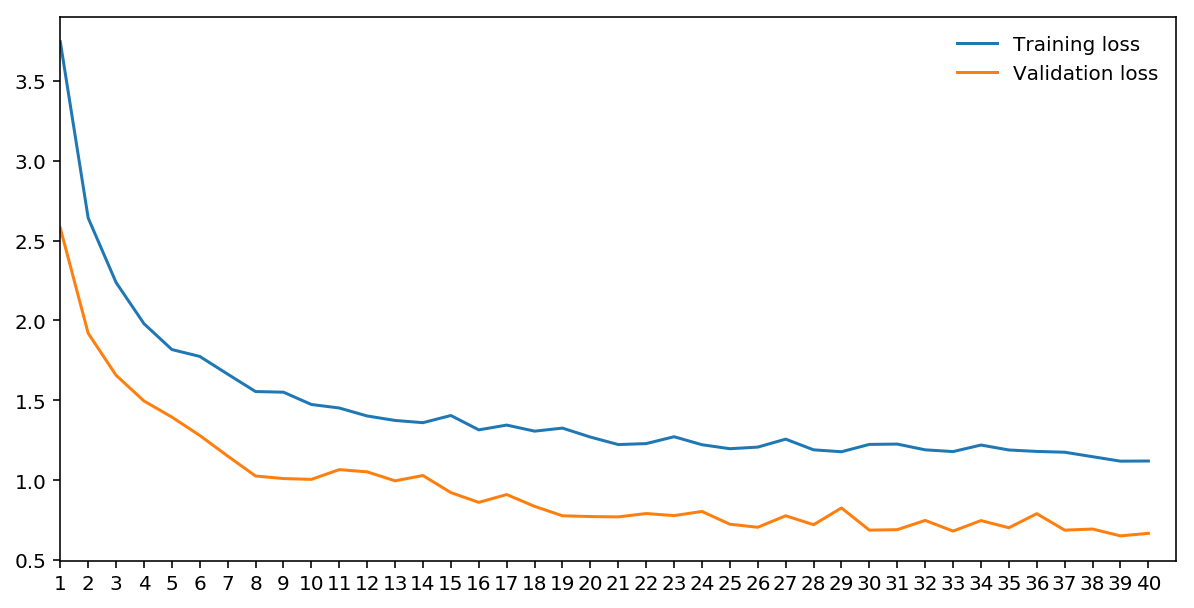

In [27]:
plot_loss(metrics_iteration_7) 

After 40 epochs decrease in loss still exhibits a downward trend. As such, let's continue training for yet another 20 epochs.

In [28]:
metrics = apply_model(epochs=20)

Training and validating model
Epoch: 1
        Train Loss (avg): 1.184
        Test Loss (avg): 0.78
        Test Accuracy (avg) 0.861
        -------------------
Epoch: 2
        Train Loss (avg): 1.14
        Test Loss (avg): 0.66
        Test Accuracy (avg) 0.881
        -------------------
Epoch: 3
        Train Loss (avg): 1.16
        Test Loss (avg): 0.644
        Test Accuracy (avg) 0.868
        -------------------
Epoch: 4
        Train Loss (avg): 1.121
        Test Loss (avg): 0.734
        Test Accuracy (avg) 0.861
        -------------------
Epoch: 5
        Train Loss (avg): 1.163
        Test Loss (avg): 0.656
        Test Accuracy (avg) 0.861
        -------------------
Epoch: 6
        Train Loss (avg): 1.144
        Test Loss (avg): 0.741
        Test Accuracy (avg) 0.862
        -------------------
Epoch: 7
        Train Loss (avg): 1.169
        Test Loss (avg): 0.637
        Test Accuracy (avg) 0.864
        -------------------
Epoch: 8
        Train Loss (avg): 1

In [29]:
with open("metrics_iteration_7_40_epochs", "r") as f_in:
    metrics_iteration_7_40_epochs = json.load(f_in)
   
for k in metrics_iteration_7_40_epochs.keys():
    metrics_iteration_7_40_epochs[k].extend(metrics[k])
    
with open("metrics_iteration_7_60_epochs", "w") as f_out:
    json.dump(metrics_iteration_7_40_epochs, f_out) 

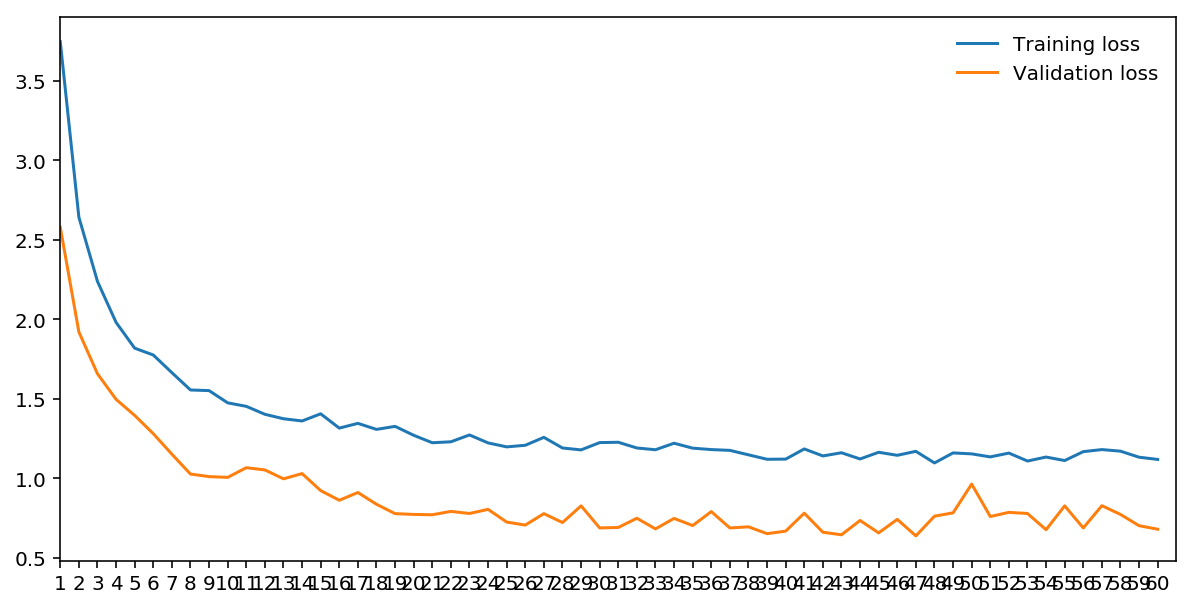

In [31]:
plot_loss(metrics_iteration_7_40_epochs)

The model from iteration 7 in combination with 60 epochs exibits very low training loss and validation loss. Furthermore, validation accuracy exibits highest values (approxs. 85%-87%). Even more noteworthy is the result that highest accuracy values result for a stretch of the last consecutive 20 epochs. This is indicative of the model having converged to acceptable model parameter values. As such, I will use the model from iteration 7 trained for 60 epochs as the final model.   

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# TODO: Do validation on the test set
apply_model(only_validate=test_dataloader)

Only validation activated
Test loss: 0.633
Test accuracy: 0.855


The final model achieves good results, exhibiting 85% accuracy on the test set. 

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

## Save model representation iteration 7

In [18]:
# TODO: Save the checkpoint 
# convert idx class representation to int
# -> not required, but allows direct mapping to class names without converting top class prediction to str
checkpoint = {'input_size': classifier.input_size,
              'output_size': classifier.output_size,
              'hidden_layers': [hl.out_features for hl in classifier.hidden_layers],
              'state_dict': model.state_dict(),
              'epochs':60,
              'class_to_idx': {int(k):v for k,v in cat_to_name.items()},
              'optimizer_state': optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint_iteration_7.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [68]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(filepath):
    # map to available device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_checkpoint = torch.load(filepath, map_location=device.type)
    
    # load used pre-trained model and freeze weights of pre-trained model
    # -> as previously, freeze weights of pre-trained model if further training of fc layers intended
    model = models.vgg11(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    # add fc network and load trained weights  
    model.classifier = Classifier(model_checkpoint["input_size"], 
                                  model_checkpoint["output_size"], 
                                  model_checkpoint["hidden_layers"])

    model.load_state_dict(model_checkpoint["state_dict"])
    model.class_to_idx = model_checkpoint["class_to_idx"]
    return model, model_checkpoint

In [69]:
model, model_checkpoint = load_model("checkpoint_iteration_7.pth")

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

Open any image to test process_image implemenattion

In [93]:
image_paths = []
flowers_path = os.path.join(os.getcwd(), "flowers", "test")
for subdir, dirs, files in os.walk(flowers_path):
    for file in files:
        if "image" in file:
            image_paths.append(os.path.join(subdir, file))            

In [137]:
ref_image = Image.open(image_paths[10])

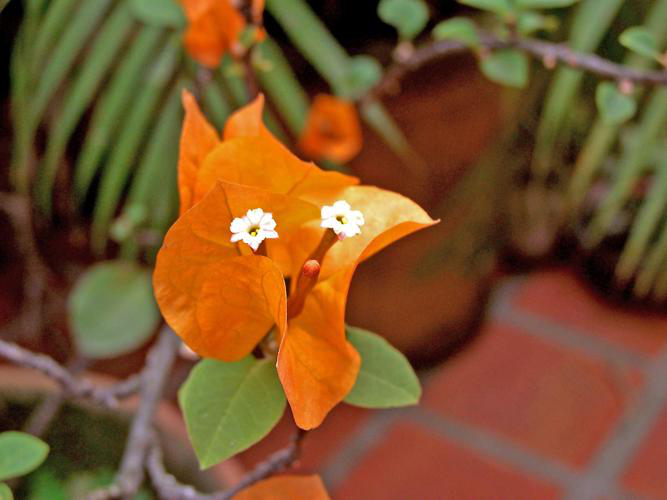

In [138]:
ref_image

In [98]:
def process_image(image, resize=255, crop_size=224):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    width, height = image.size 
    aspect_ratio = max(width, height)/min(width, height)
    size = (resize, int(resize*aspect_ratio)) if np.argmin(image.size) == 0 else (int(resize*aspect_ratio), resize)     
    image = image.resize(size)
    # resized image 
    width, height = image.size
    
    # define centered image format
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2

    image = image.crop((left, top, right, bottom))
    image = np.array(image)
    # standarize values to be within 0-1 range
    image_standarized = image/255
    # normalize
    mean_norm_factors = [0.485, 0.456, 0.406]
    std_norm_factors = [0.229, 0.224, 0.225]
    image_normalized = (image_standarized-mean_norm_factors)/std_norm_factors
    # specify order of axes; otherwise image will be rotated by 90 deg
    image_normalized = image_normalized.transpose(2,0,1)
    return image_normalized 

In [99]:
image_transformed = process_image(ref_image)   

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [79]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

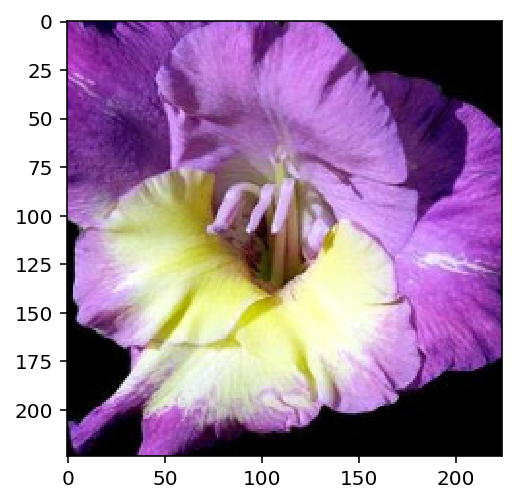

In [80]:
imshow(torch.from_numpy(image_transformed))

A cropped version with the specified format (224x224 and centered) indicates that the function is correctly implemented.

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [100]:
def predict(image_path, model, topk=5, show_im=False):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    image = Image.open(image_path)
    image = process_image(image)
    image_tensor = torch.from_numpy(image)
    # refactor tensor shape to cope with model specification 
    if show_im:
        imshow(image_tensor)
    image_tensor = image_tensor.view(1,*image_tensor.shape)
    image_tensor = image_tensor.type(torch.FloatTensor)
    with torch.no_grad():
        model.eval()
        
        output = model.forward(image_tensor)
        probs = torch.exp(output)
        class_probs, class_idx = probs.topk(topk, dim=1)
        return class_probs, class_idx

In [101]:
class_probs, class_idx = predict(image_paths[5],model)

In [102]:
class_probs

tensor([[1.0000e+00, 9.7706e-16, 6.4873e-27, 6.6369e-31, 2.9174e-31]])

In [103]:
class_idx

tensor([[60, 82, 16, 80, 58]])

In [72]:
ls

IMG_3397.JPG                    flowers.zip
IMG_3399.JPG                    metrics_iteration_1
IMG_3400.JPG                    metrics_iteration_7
IMG_3402.JPG                    metrics_iteration_7_40_epochs
Image Classifier Project.html   metrics_iteration_7_60_epochs
Image Classifier Project.ipynb  model.py
__pycache__/                    predict.py
checkpoint_iteration_1.pth      train.py
checkpoint_iteration_7.pth      utilities.py
flowers/


In [155]:
im="IMG_3399.JPG"
class_probs, class_idx = predict(im,model)

In [156]:
class_probs

tensor([[9.9903e-01, 2.5619e-04, 2.2496e-04, 9.1417e-05, 7.4615e-05]])

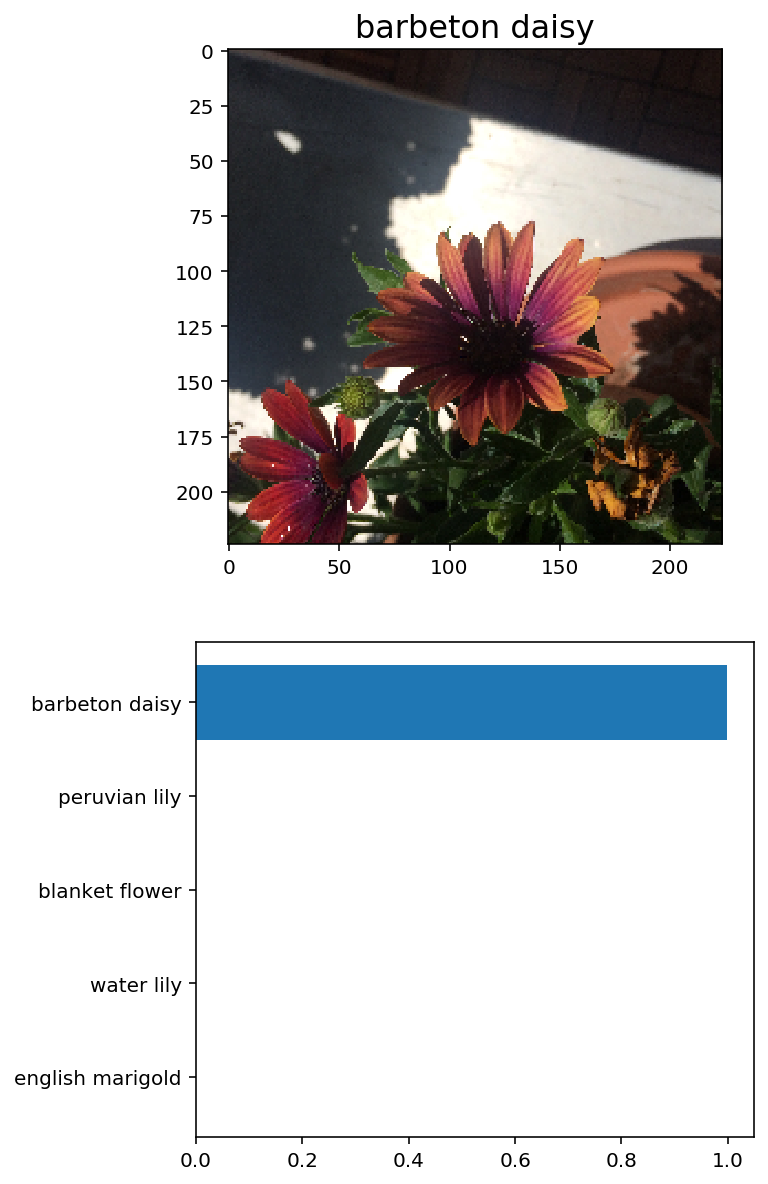

In [157]:
display_prediction(im, class_idx)

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

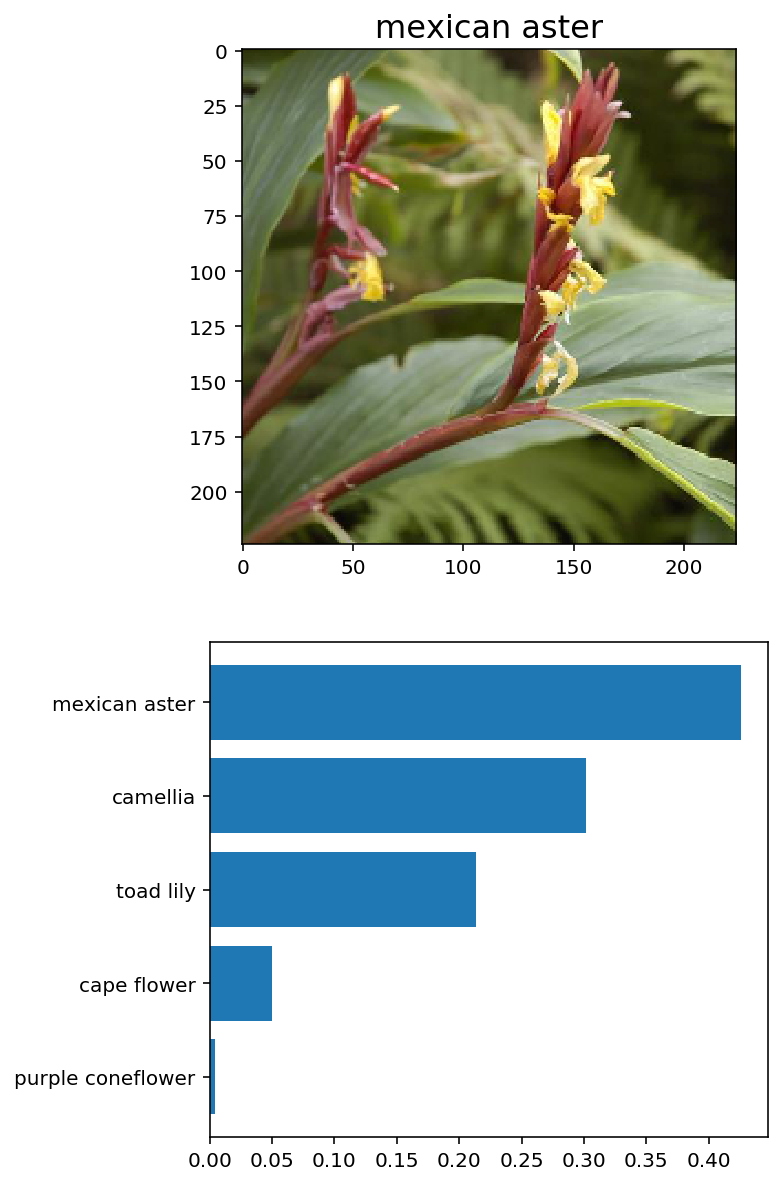

In [95]:
# TODO: Display an image along with the top 5 classes
def display_prediction(image_path, class_idx):
    image = Image.open(image_path)
    image_transformed = process_image(image)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
    class_idx_rev = class_idx.numpy()[0][::-1]
    y_ticks = list(range(5))
    ax[1].barh(y_ticks, list(class_probs.numpy()[0])[::-1])
    ax[1].set_yticks(y_ticks)
    ax[1].set_yticklabels([model.class_to_idx[idx] for idx in class_idx_rev])
    imshow(torch.from_numpy(image_transformed), ax[0])
    ax[0].set_title(model.class_to_idx[list(class_idx.numpy()[0])[0]], fontsize=16)

    plt.show()
    
display_prediction(image_paths[5], class_idx)   

While testing the model's prediction results using a random image set from the test dataset, I encountered some inconsistencies with respect to the top class predicted, i.e. high probability (>90%) for the top class but the corresponding trivial class name does not seem to be correct. 

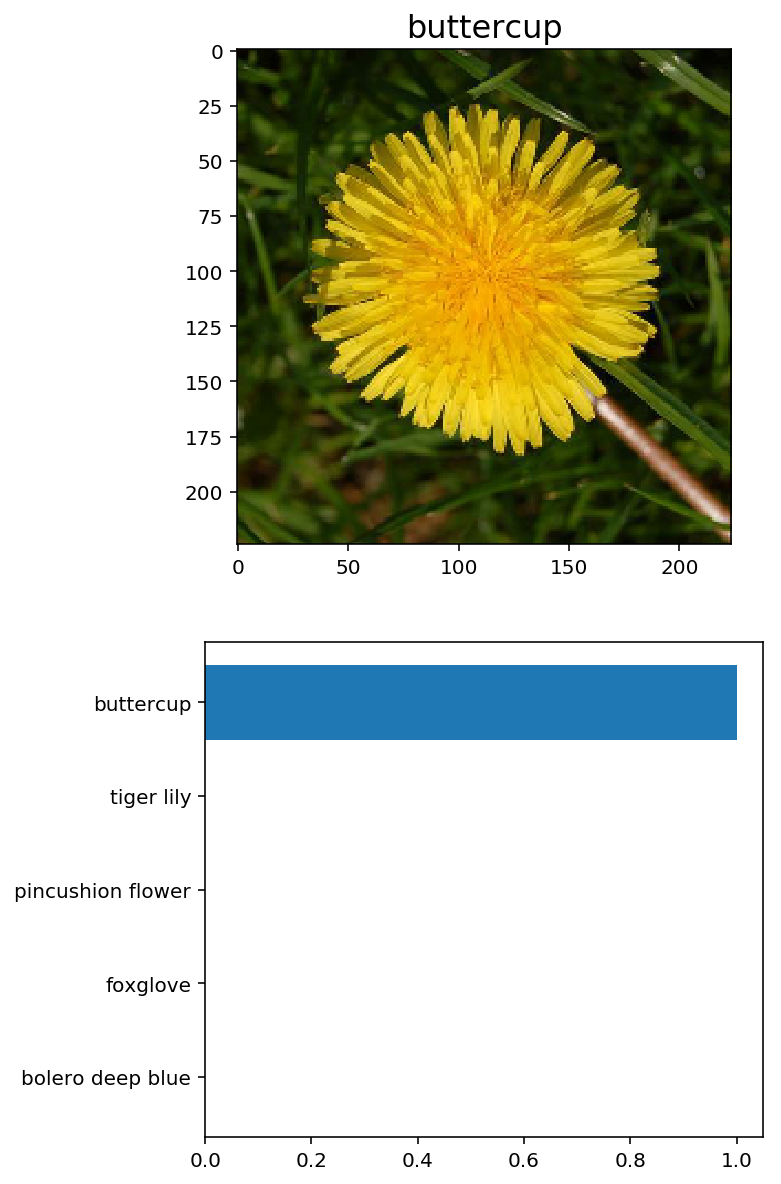

In [44]:
im_path = os.path.join(os.getcwd(), 'flowers/test/50/image_06547.jpg')
class_probs, class_idx = predict(im_path, model)
display_prediction(im_path, class_idx)

Here we have an image of a common dandelion as input. However, with almost 100% accuracy our model returns buttercup as the top class. If the model has not been trained well, we would expect a more uniform distribution of class probabilities (reflecting random guessing). 
Similar results have been obtained with other example images, i.e. high probability for the top class but the returned class name does not correspond to the input image (based on domain knowledge and google search). So it seems that somehow class labels are not correct. This could be either attributable to the class_to_idx dictionary used to map from class index returned by our model to the trivial class name, or to the imageloader used to query image batches and cognate class labels.  

So let's have a look at the imageloader and compare with the class_to_idx dictionary. For convenience set shuffle to False in order to better map classes obtained by the imageloader with the input dataset.

In [17]:
test_data = datasets.ImageFolder(test_dir, transform=valid_test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [18]:
im, label = next(iter(test_dataloader))

In [19]:
label

tensor([  0,   0,   0,   0,   0,   1,   1,   1,   2,   2,   2,   2,
          2,   2,   2,   2,   3,   3,   3,   3,   4,   4,   4,   4,
          4,   4,   5,   5,   5,   5,   5,   5,   5,   5,   5,   6,
          6,   6,   6,   6,   6,   6,   6,   6,   7,   7,   7,   7,
          7,   7,   8,   8,   8,   9,   9,   9,   9,  10,  10,  10,
         11,  11,  11,  11])

These are the classes for the first batch of 64 images. The imgs attribute on the test_data is a list of tuples, each encompassing the image file paths and an int that seems to correspond to the class idx. 
Indeed, labels of the first image batch returned by the dataloader are equal to the first 64 entries in the imgs list.

In [8]:
test_data.imgs[:20]

[('flowers/test/1/image_06743.jpg', 0),
 ('flowers/test/1/image_06752.jpg', 0),
 ('flowers/test/1/image_06754.jpg', 0),
 ('flowers/test/1/image_06760.jpg', 0),
 ('flowers/test/1/image_06764.jpg', 0),
 ('flowers/test/10/image_07090.jpg', 1),
 ('flowers/test/10/image_07104.jpg', 1),
 ('flowers/test/10/image_07117.jpg', 1),
 ('flowers/test/100/image_07896.jpg', 2),
 ('flowers/test/100/image_07897.jpg', 2),
 ('flowers/test/100/image_07899.jpg', 2),
 ('flowers/test/100/image_07902.jpg', 2),
 ('flowers/test/100/image_07926.jpg', 2),
 ('flowers/test/100/image_07936.jpg', 2),
 ('flowers/test/100/image_07938.jpg', 2),
 ('flowers/test/100/image_07939.jpg', 2),
 ('flowers/test/101/image_07949.jpg', 3),
 ('flowers/test/101/image_07952.jpg', 3),
 ('flowers/test/101/image_07983.jpg', 3),
 ('flowers/test/101/image_07988.jpg', 3)]

Intriguingly, class index 0 is not represented in the class_to_idx dictionary, which indicates inconsistencies between labels returned by the imageloader and the class_to_idx dictionary. 

In [27]:
set(label.numpy()).difference(set(model.class_to_idx.keys()))

{0}

Having a closer look at the file path structure reveals that each image path contains a digit, which in turn seems to be part of a sequence of numbers from 1 to 102. Essentially, this sequence reflects the class index sequence from the dictionary used for mapping.

In [30]:
print(sorted(list(model.class_to_idx.keys())))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]


Let's do one last sanity check and evaluate key:value pairs from the class_to_idx dictionary that represent well known, or let's say "easy to identify" plants. Let's visualize images that have the same index value within the corresponding image file path (e.g. sunflower and rose).

In [33]:
print(model.class_to_idx[54])
print(model.class_to_idx[74])

sunflower
rose


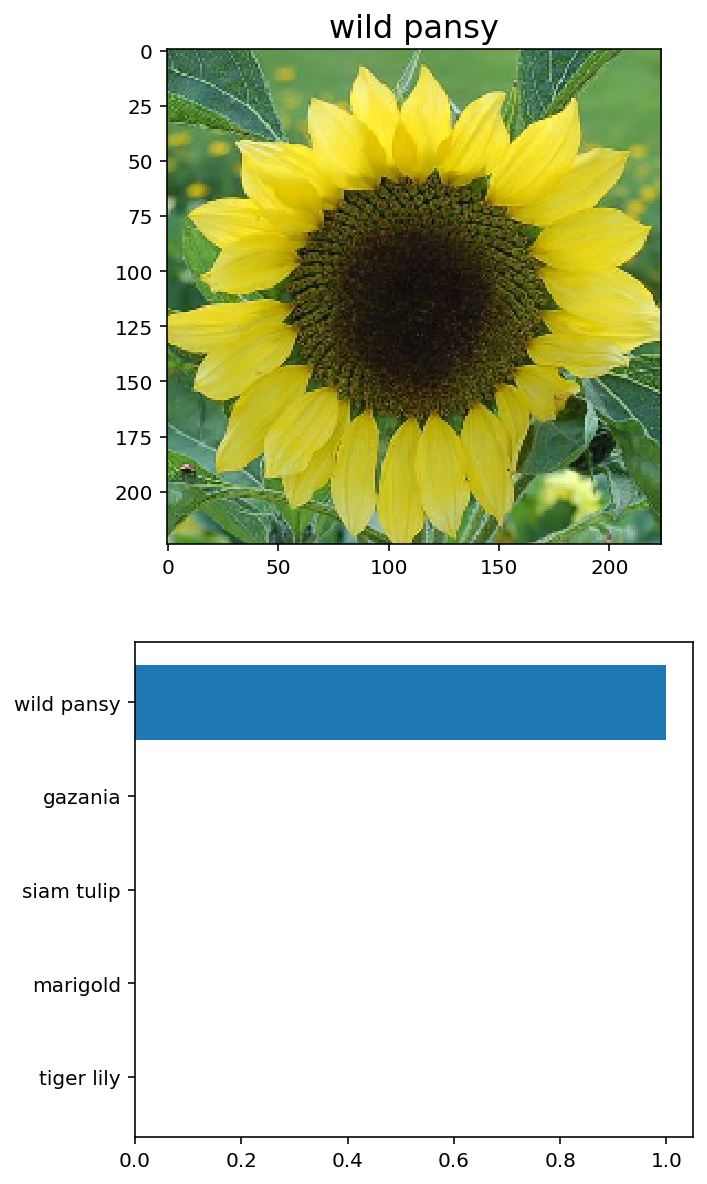

In [115]:
im_path = os.path.join(os.getcwd(), 'flowers/test/54/image_05402.jpg')
class_probs, class_idx = predict(im_path, model)
display_prediction(im_path, class_idx)

Clearly the predicted class is wrong. So actually the digit with the file path matches the key:value pair in the class_to_idx dictionary (54:sunflower). However, the predicted class matches the class label encoding from the dataloader, i.e. index 52 encodes "wild pansy" (see test_data.imgs in the section above)

In [47]:
model.class_to_idx[52]

'wild pansy'

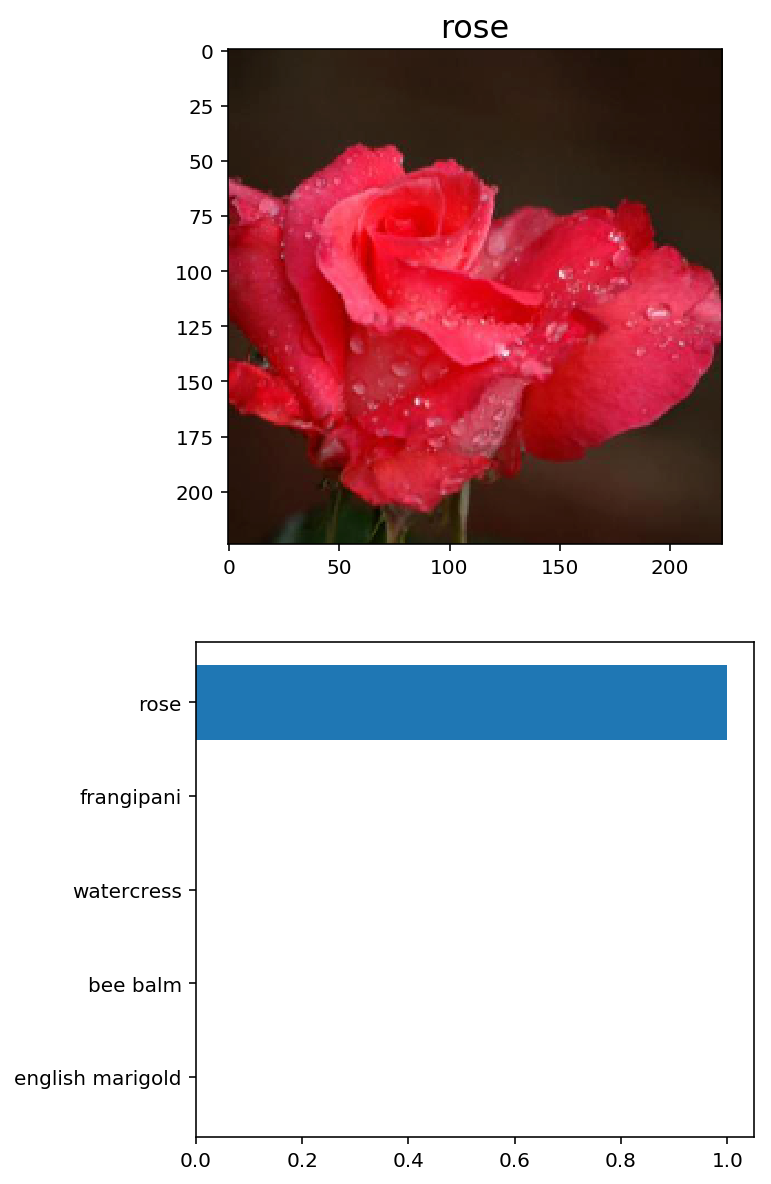

In [49]:
im_path = os.path.join(os.getcwd(), 'flowers/test/74/image_01200.jpg')
class_probs, class_idx = predict(im_path, model)
display_prediction(im_path, class_idx)

Intrestingly, the class index for "rose" encoded in the class_to_idx dictionary actually corresponds to the class label returned by the dataloader. 
Nevertheless, it really seems that the class labels returned by the dataloader are actually wrong for most classes and that the true class label should correspond to the digits encoded in the image file paths. So let's map the class labels returned by the dataloader to the true index values and update the display_prediction function accordingly.

In [120]:
class_idx_correction = {}
for path, class_var in test_data.imgs:
    ref = path
    match = re.search(r"\d+", re.search(r"\/\d+\/", ref).group()).group()
    class_idx_correction[class_var] = int(match)

In [265]:
with open ("class_idx_correction.json", "w") as f_out:
    json.dump(class_idx_correction, f_out)

In [271]:
class_idx_correction

{0: 1,
 1: 10,
 2: 100,
 3: 101,
 4: 102,
 5: 11,
 6: 12,
 7: 13,
 8: 14,
 9: 15,
 10: 16,
 11: 17,
 12: 18,
 13: 19,
 14: 2,
 15: 20,
 16: 21,
 17: 22,
 18: 23,
 19: 24,
 20: 25,
 21: 26,
 22: 27,
 23: 28,
 24: 29,
 25: 3,
 26: 30,
 27: 31,
 28: 32,
 29: 33,
 30: 34,
 31: 35,
 32: 36,
 33: 37,
 34: 38,
 35: 39,
 36: 4,
 37: 40,
 38: 41,
 39: 42,
 40: 43,
 41: 44,
 42: 45,
 43: 46,
 44: 47,
 45: 48,
 46: 49,
 47: 5,
 48: 50,
 49: 51,
 50: 52,
 51: 53,
 52: 54,
 53: 55,
 54: 56,
 55: 57,
 56: 58,
 57: 59,
 58: 6,
 59: 60,
 60: 61,
 61: 62,
 62: 63,
 63: 64,
 64: 65,
 65: 66,
 66: 67,
 67: 68,
 68: 69,
 69: 7,
 70: 70,
 71: 71,
 72: 72,
 73: 73,
 74: 74,
 75: 75,
 76: 76,
 77: 77,
 78: 78,
 79: 79,
 80: 8,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 9,
 92: 90,
 93: 91,
 94: 92,
 95: 93,
 96: 94,
 97: 95,
 98: 96,
 99: 97,
 100: 98,
 101: 99}

In [60]:
class_idx.numpy().flatten()

array([74, 81, 89, 92,  5])

In [61]:
[class_idx_correction[idx] for idx in class_idx.numpy().flatten()]

[74, 80, 88, 90, 11]

In [140]:
def display_prediction(image_path, class_idx):
    image = Image.open(image_path)
    image_transformed = process_image(image)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
    class_idx = [class_idx_correction[idx] for idx in class_idx.numpy().flatten()]
    class_idx_rev = class_idx[::-1]
    
    y_ticks = list(range(5))
    ax[1].barh(y_ticks, list(class_probs.numpy()[0])[::-1])
    ax[1].set_yticks(y_ticks)
    ax[1].set_yticklabels([model.class_to_idx[idx] for idx in class_idx_rev])
    imshow(torch.from_numpy(image_transformed), ax[0])
    ax[0].set_title(model.class_to_idx[class_idx[0]], fontsize=16)

    plt.show()

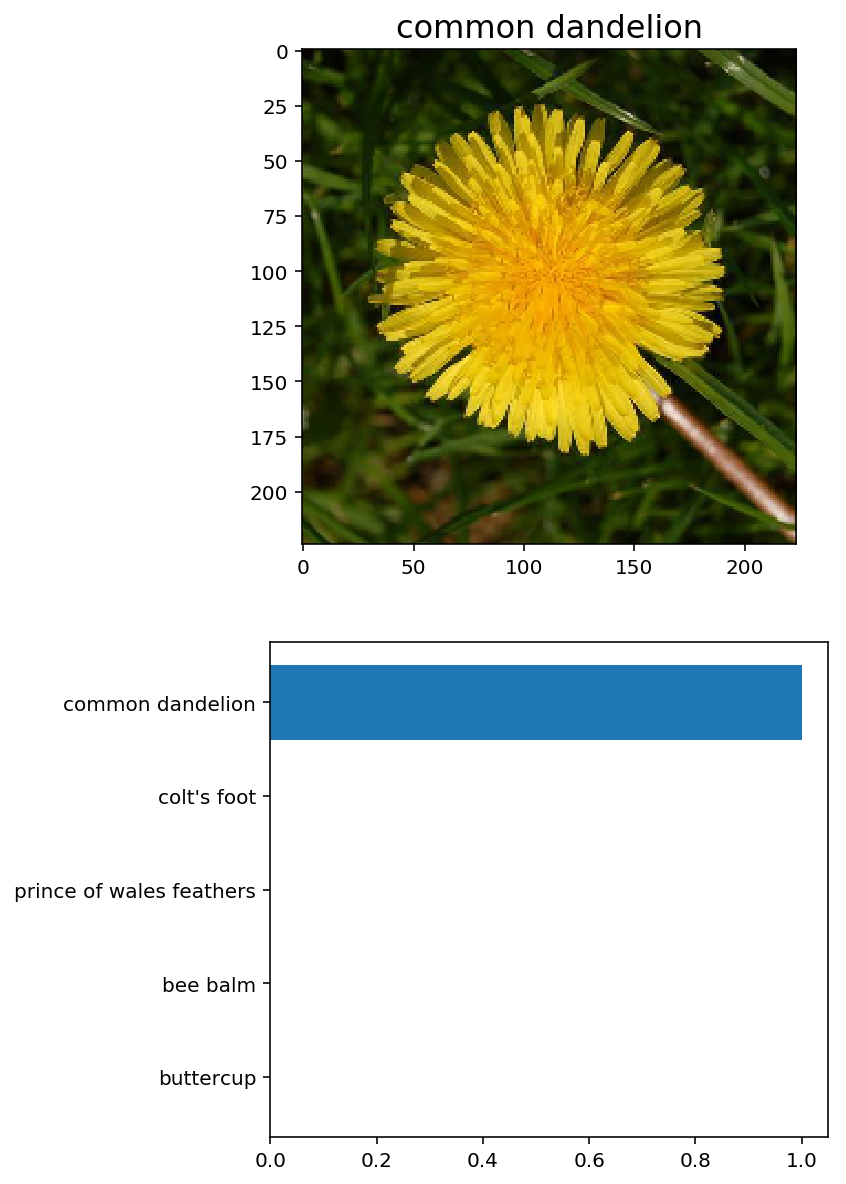

In [65]:
im_path = os.path.join(os.getcwd(), 'flowers/test/50/image_06547.jpg')
class_probs, class_idx = predict(im_path, model)
display_prediction(im_path, class_idx)

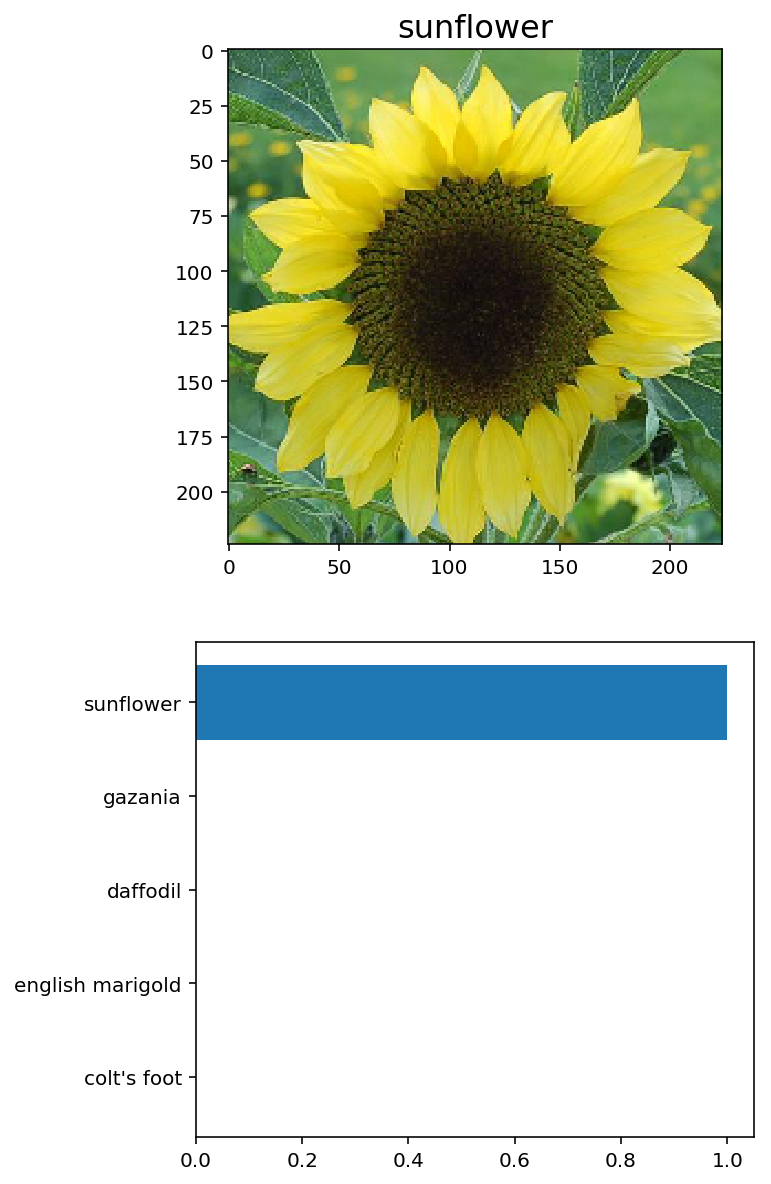

In [66]:
im_path = os.path.join(os.getcwd(), 'flowers/test/54/image_05402.jpg')
class_probs, class_idx = predict(im_path, model)
display_prediction(im_path, class_idx)

With the implementation of remapping of class indices the predicted class names now make sense